In [42]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from khmernltk import word_tokenize

In [43]:
train_set = pd.read_excel('Data\dataset.xlsx')
test_set = pd.read_excel('Data\testing_set3.xlsx')

In [44]:
# Tokenization (Assume each entity is a single token for simplicity)
train_set['word'] = train_set['entity']
test_set['word'] = test_set['entity']

In [45]:
def tokenize(sen): return word_tokenize(sen)

In [46]:
def extract_features(df):
    df['prefix'] = df['word'].apply(lambda x: x[:3])
    df['suffix'] = df['word'].apply(lambda x: x[-3:])
    return df

In [47]:
train_set = extract_features(train_set)
test_set = extract_features(test_set)

In [48]:
train_set

,entity,label,word,prefix,suffix
0,អាហ្រ្វិកខាងត្បូង,LOC,អាហ្រ្វិកខាងត្បូង,អាហ,បូង
1,ប្រទេសអូស្រ្តាលី,LOC,ប្រទេសអូស្រ្តាលី,ប្រ,ាលី
2,លោកអំសំអាត,PER,លោកអំសំអាត,លោក,អាត
3,ជំងឺគ្រោះថ្នាក់សរសៃឈាមអាទែរ,DIS,ជំងឺគ្រោះថ្នាក់សរសៃឈាមអាទែរ,ជំង,ទែរ
4,អ៊ីស្រាអែល,LOC,អ៊ីស្រាអែល,អ៊ី,អែល
...,...,...,...,...,...
873,ឃុំល្វែងឫស្សី,LOC,ឃុំល្វែងឫស្សី,ឃុំ,្សី
874,ឃុំពង្រក្រោម,LOC,ឃុំពង្រក្រោម,ឃុំ,រោម
875,ឃុំឫស្សីលក,LOC,ឃុំឫស្សីលក,ឃុំ,ីលក
876,ឃុំសង្វើយ,LOC,ឃុំសង្វើយ,ឃុំ,វើយ


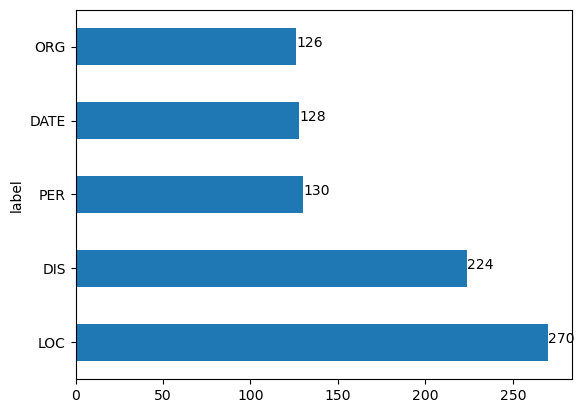

In [49]:
train_set['label'].value_counts().plot(kind='barh')
# add data label
for i, v in enumerate(train_set['label'].value_counts()):
    plt.text(v, i, str(v), color='black')
plt.show()

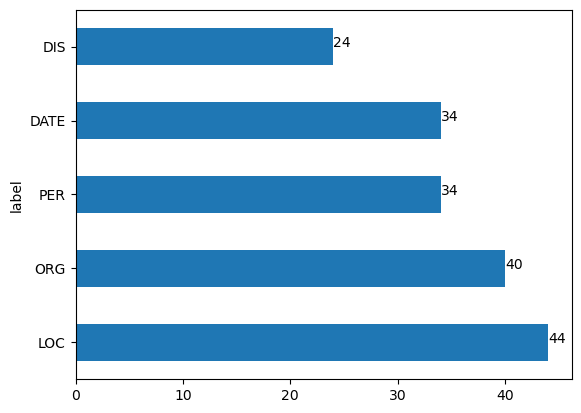

In [50]:
test_set['label'].value_counts().plot(kind='barh')
# add data label
for i, v in enumerate(test_set['label'].value_counts()):
    plt.text(v, i, str(v), color='black')
plt.show()

In [51]:
# Step 2: Convert Features to Numerical Vectors
X_train = train_set[['word', 'prefix', 'suffix']].to_dict(orient='records')
y_train = train_set['label']

X_test = test_set[['word', 'prefix', 'suffix']].to_dict(orient='records')
y_test = test_set['label']

In [52]:
len(X_train), len(X_test)

(878, 176)

In [53]:
# Step 4: Train Random Forest Model using a Pipeline
vec = DictVectorizer(sparse=False)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [54]:
pipeline = Pipeline([
    ('vectorizer', vec),
    ('classifier', rf)
])

In [55]:
# train model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', DictVectorizer(sparse=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [56]:
# Step 5: Evaluate the Model
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        DATE       1.00      0.97      0.99        34
         DIS       1.00      0.88      0.93        24
         LOC       0.68      0.93      0.79        44
         ORG       0.91      0.80      0.85        40
         PER       1.00      0.79      0.89        34

    accuracy                           0.88       176
   macro avg       0.92      0.87      0.89       176
weighted avg       0.90      0.88      0.88       176



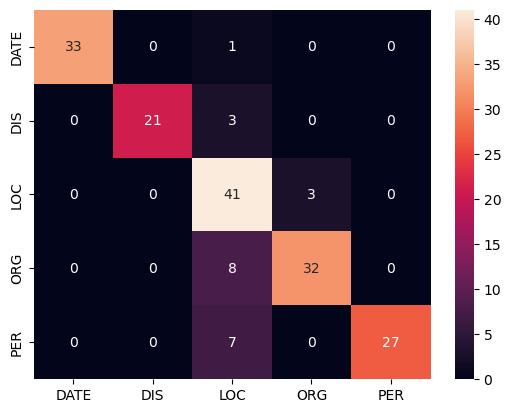

In [57]:
# display confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# add class name in heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.show()

In [58]:
# create a function for testing unseen data
# def predict_label(text):
#     X = extract_features(pd.DataFrame({'word': [text]}))
#     X = X[['word', 'prefix', 'suffix']].to_dict(orient='records')
#     pred_label = pipeline.predict(X)[0]
#     return pred_label

In [59]:
def predict_label(text, threshold=0.75):
    # Extract features from the input text
    X = extract_features(pd.DataFrame({'word': [text]}))
    X = X[['word','prefix', 'suffix']].to_dict(orient='records')
    
    # Get the probability estimates for each class
    pred_proba = pipeline.predict_proba(X)[0]
    
    # Get the predicted label and its confidence score
    max_proba = max(pred_proba)
    pred_label = pipeline.classes_[pred_proba.argmax()]
    
    # Check if the confidence is above the threshold
    # print(max_proba)
    if max_proba >= threshold:
        return pred_label
    else:
        return 'Unknown Class'  # or 'unknown' for entities outside your 5 classes

In [60]:
print(predict_label("ជំទាវ"))

LOC


In [61]:
def tokenize(sen): 
    tokens = word_tokenize(sen)
    # remove element that is equal space
    tokens = [t for t in tokens if t != ' ']
    tokens = [i for i in tokens if i]
    return tokens

In [62]:
def input(sen):
    result = []
    tokens = tokenize(sen)
    bi_gram_tokens = []
    # implement Bi-gram
    # for i in range(len(tokens)-1):
    #     bi_gram_tokens.append(tokens[i] + tokens[i+1])
    for token in tokens:
        result.append((token, predict_label(token)))
    # print(result)
    return result

In [63]:
test = "ក្រសួង​សុខាភិ​បាល​កម្ពុជា​បាន​ប្រកាសរក​ឃើញ​ជំងឺ​អឹម​ផក"

In [64]:
re = input(test)

for x in re:
    print(x)

('ក្រសួង', 'ORG')
('សុខាភិបាល', 'Unknown Class')
('កម្ពុជា', 'Unknown Class')
('បាន', 'LOC')
('ប្រកាស', 'LOC')
('រកឃើញ', 'LOC')
('ជំងឺ', 'DIS')
('អឹម', 'LOC')
('ផក', 'LOC')
